# Update 22/10/2023:

Minhf batws đầu đi sâu hơn về các khái niệm liên quan tới query, key và value và tại sao đầu ra của Self Attention lại là một ma trận liên kết và cập nhật value mới.

Có một stack khá hay mà minh thấy trên gg: https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms




# Generate Data

In [1]:
# import
import numpy as np
import math

In [6]:
# L là số chiều của vector sau khi embedding
# d_q, d_k, d_v lần lượt là chiều của các ma trận query, key và value
L,d_q, d_k, d_v = 4, 8,  8, 8
# Khởi tạo ma trận Weights Query, key và Values
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)

In [7]:
print("Q\n", q)
print("K\n", k)
print("V\n", v)

Q
 [[ 0.70912678  2.01887231  0.88679928  1.13074244  2.11280041 -0.16365592
   0.07336851  0.74810736]
 [-0.4192163   0.67645366  0.1608843  -1.07909591 -0.39111049  0.10899728
   0.25340865 -1.7557638 ]
 [-0.18377444 -1.47977227 -0.26008033  2.1830005  -0.04951231 -0.05257607
   0.4446961   0.21496057]
 [ 1.37208902 -1.40927922 -1.44813741 -0.15482545  0.10140968  1.25976085
  -0.12326459  1.42144565]]
K
 [[ 1.23980356  1.06308991 -1.51274677 -1.18338862  1.13022255  0.21053416
  -0.18106796 -1.03125502]
 [-0.40362144  0.03472953 -0.58649893 -0.14535926  0.7204221  -1.55311486
   0.43312285  0.59226455]
 [ 0.38326    -1.14824613 -1.58248394 -0.61302487  1.45089261  1.45287712
   0.27924221 -1.26438353]
 [ 0.50230425 -0.49264452  0.68439683 -0.05560643  0.0308127   0.27390187
   0.99851564  0.48637834]]
V
 [[ 0.13968361  0.87092095  0.00256411  1.67443353 -0.1372076  -0.89017086
   0.54519707 -2.36301112]
 [ 2.12358703  0.46854265 -0.88617323 -0.16716779 -1.52227016  0.52077953
   0.1

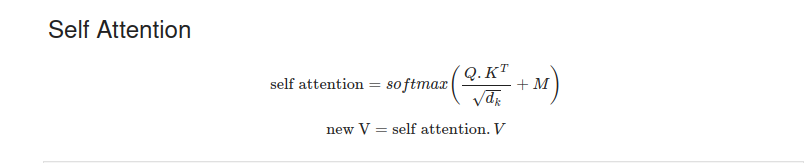

In [8]:
# Tính phần đầu Q.K ( Tính query và value)
np.matmul(q, k.T)

array([[ 1.91451554,  1.35056459, -2.24063373,  0.36305532],
       [ 2.57865961, -1.1259738 ,  1.35113326, -0.95684153],
       [-4.3601058 ,  0.2239095 ,  0.40621044,  0.86996588],
       [ 1.51309873, -0.82592416,  4.67637142,  1.31744278]])

In [12]:
# Why we need sqrt(d_k) in denominator
# Check Phương sai của ma trận
# -> Chia căn d dể hợp lý hơn
q.var(), k.var(), np.matmul(q, k.T).var()

(1.0085212120761708, 0.7901718583223803, 4.046692023231386)

In [13]:
# Scaled step
scaled = np.matmul(q, k.T)/math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(1.0085212120761708, 0.7901718583223803, 0.5058365029039232)

In [14]:
scaled

array([[ 0.67688346,  0.47749669, -0.79218365,  0.12835944],
       [ 0.91169385, -0.39809186,  0.47769774, -0.33829457],
       [-1.54153019,  0.07916396,  0.14361708,  0.30757939],
       [ 0.53496118, -0.29200829,  1.65334697,  0.46578636]])

# Masking


    This is to ensure words don't get context from words generated in the future.
    Not required in the encoders, but required int he decoders


In [15]:
# Khởi tạo ma trận tam giác trên bằng hàm tril
mask = np.tril(np.ones( (L, L) ))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [16]:
mask[mask == 0] = -np.infty
mask[mask == 1] = 0

In [18]:
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [19]:
scaled + mask

array([[ 0.67688346,        -inf,        -inf,        -inf],
       [ 0.91169385, -0.39809186,        -inf,        -inf],
       [-1.54153019,  0.07916396,  0.14361708,        -inf],
       [ 0.53496118, -0.29200829,  1.65334697,  0.46578636]])

## Softmax

In [20]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [23]:
attention = softmax(scaled + mask)

In [24]:
# Hiện tại tính attention không xét thêm M ( giống kiểu bias )
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.78747729, 0.21252271, 0.        , 0.        ],
       [0.08733743, 0.44163039, 0.47103218, 0.        ],
       [0.1841469 , 0.08054084, 0.5634731 , 0.17183917]])

In [25]:
# Get new V
new_v = np.matmul(attention, v)
new_v

array([[ 0.13968361,  0.87092095,  0.00256411,  1.67443353, -0.1372076 ,
        -0.89017086,  0.54519707, -2.36301112],
       [ 0.56130813,  0.78540642, -0.18631275,  1.28305143, -0.43156484,
        -0.59031187,  0.45308028, -1.58959637],
       [ 0.98870342, -0.29809864, -0.22302332,  0.39621455,  0.27441058,
         1.13094335, -0.08555426,  0.6863769 ],
       [ 0.21692397, -0.47045258,  0.42306665,  0.6716483 ,  1.0346846 ,
         0.87576027, -0.14082184, -0.09010446]])

# Create like function

In [ ]:
# KHởi tạo hàm softmax
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

# Khởi tạo hàm tính attention
def scaled_dot_product_attention(q, k, v, mask=None):
    # Xét chiều
    d_k = q.shape[-1]

    # Tính và sclaed query và key
    scaled = np.matmul(q, k.T) / math.sqrt(d_k)

    # Xét mask : Chỉ dùng mask cho chiều decoder
    if mask is not None:
        scaled = scaled + mask

    # Tính attention qua softmax (chưa xét bias)
    attention = softmax(scaled)
    out = np.matmul(attention, v)

    return out, attention

